In [1]:
import torch
import torch.nn as nn

from torchvision import datasets, transforms
import torch.optim as optim

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

from tqdm.auto import tqdm


# Xarxes convolucionals

L'objectiu d'avui és la creació d'una xarxa convolucional que obtengui **com a mínim igual resultat que la xarxa completament connectada implementada la setmana anterior però amb menys paràmetres**. Per poder realitzar comparacions directes emprarem el mateix conjunt de dades.

Com objectius secundaris tenim:

1. Aprenentatge de noves estratègies per evitar `overfitting`.
2. Visualització dels resultats dels filtres convolucionals.

Primer de tot, com sempre, les dades:

In [2]:
DOWNLOAD = False
BATCH_SIZE = 64
EPOCHS = 5

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),  # mitjana, desviació típica
])

train = datasets.MNIST("../data", train=True, download=DOWNLOAD, transform=transform)
test = datasets.MNIST("../data", train=False, download=DOWNLOAD, transform=transform)

train_loader = torch.utils.data.DataLoader(train, BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test, BATCH_SIZE)

In [3]:
img, target = next(iter(train_loader))
print(img.shape)

torch.Size([64, 1, 28, 28])


## Definició de la xarxa

En primer lloc, reutilitzarem la xarxa (MLP) que varem dissenyar la sessió anterior:

In [4]:
model_mlp = nn.Sequential(
            torch.nn.Linear(784, 10),
            nn.ReLU(),
            torch.nn.Linear(10, 10),
            #torch.nn.Dropout(0.2),
            nn.ReLU(),
            torch.nn.Linear(10, 1)
        )


En segon lloc, definirem la nostra primera xarxa convolucional:

1. Definir la primera xarxa convolucional. A continuació teniu una llista de les capes que podeu emprar:

- `Conv2d`: Capa convolucional en 2 dimensions ([enllaç](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)). Com a paràmetres principals trobarem: ([visualització](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md))

  - in_channels: canals d'entrada.
  - out_channels : canals de sortida.
  - kernel_size: mida del filtre.
  - stride: desplaçament del filtre. Típicament pren per valor 1.
  - padding: ampliació de la imatge per evitar pèrdua de dimensionalitat.

- `MaxPool2d`: Capa de max pooling ([enllaç](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d)). Aquesta capa no té paràmetres entrenables. Però en té d'altres:

  - kernel_size: Mida del filtre del qual es seleccionarà el màxim.
  - stride: desplaçament del filtre.

- `Dropout`: Dropout és un mètode de regularització (evitar `overfitting`) que aproxima l'entrenament d'un gran nombre de xarxes neuronals amb diferents arquitectures en paral·lel. Durant l'entrenament, una part de les sortides de la capa s'ignoren aleatòriament o s'abandonen. Això té l'efecte de fer que la capa sembli i es tracti com una capa amb un nombre diferent de nodes i connectivitat a la capa anterior. En efecte, cada actualització d'una capa durant l'entrenament es realitza amb una vista diferent de la capa configurada. Hem d'especificar quines capes tenen `dropout` de manera individual. Té un únic paràmetre amb valor per defecte $p=0.5$ Els valors típics d'aquest paràmetre varien entre $0.5$ i $0.8$.

- `Linear`

- `ReLU`


In [5]:
model_cnn = nn.Sequential(
    torch.nn.Conv2d(in_channels=1 , out_channels=4 , kernel_size=(3,3) , stride=1 , padding="same" ),
    torch.nn.MaxPool2d(kernel_size=(2,2)),
    torch.nn.ReLU(),

    torch.nn.Conv2d(in_channels=4 , out_channels=8 , kernel_size=(3,3) , stride=1 , padding="same" ),
    torch.nn.MaxPool2d(kernel_size=(2,2)),
    torch.nn.ReLU(),

    torch.nn.Flatten(1),
                    
    torch.nn.Linear(392, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10,1)
    )

## Entrenament MLP

Aquesta part, per sort, no varia de la setmana anterior:




In [6]:
loss_fn = torch.nn.BCEWithLogitsLoss()    
learning_rate =  1e-3 # Hiperparàmetre
optimizer = optim.Adam(model_mlp.parameters(), lr=learning_rate)

In [7]:
running_loss = []
running_acc = []

running_test_loss = []
running_test_acc = []

for t in tqdm(range(EPOCHS), desc="Èpoques"):
    batch_loss = 0
    batch_acc = 0
    
    # Iteram els batches.
    for i_batch, (x, y) in tqdm(enumerate(train_loader), desc=f"Batches (Època {t + 1})"): 
        model_mlp.train() # Posam el model a mode entranament.
        
        x = x.reshape(x.shape[0], -1) # Aplanam la imatge.
        
        optimizer.zero_grad()

        # 1. PREDICCIÓ
        y_pred = model_mlp(x)

        # 2. CÀLCUL DE LA PÈRDUA
        # Computa la pèrdua: l'error de predicció vs el valor correcte
        # Es guarda la pèrdua en un array per futures visualitzacions

        y_binary = (y == 5)
        y_binary = y_binary.double()
        y_binary = y_binary.reshape(-1, 1)

        loss = loss_fn(y_pred, y_binary)

        #3. GRADIENT
        model_mlp.zero_grad()
        loss.backward()

        # Actualitza els pesos utilitzant l'algorisme d'actualització
        #4. OPTIMITZACIÓ
        with torch.no_grad():
            optimizer.step()
    
        # 5. AVALUAM EL MODEL
        model_mlp.eval() # Mode avaluació de la xarxa
        
        y_pred = model_mlp(x)
        y_pred_binary = (y_pred > 0.5).double()

        batch_loss += (loss_fn(y_pred, y_binary).detach())
        batch_acc += accuracy_score(y_pred_binary.detach(), y_binary.detach())

    running_loss.append(batch_loss / (i_batch + 1))
    running_acc.append(batch_acc / (i_batch + 1))

    batch_test_loss = 0
    batch_test_acc = 0
    
    for i_batch, (x, y) in enumerate(test_loader): 
        x = x.reshape(x.shape[0], -1) # Aplanam la imatge.
        
        y_binary = (y == 5)
        y_binary = y_binary.double()
        y_binary = y_binary.reshape(-1, 1)

        y_pred = model_mlp(x)
        y_pred_binary = (y_pred > 0.5).double()

        batch_test_loss += (loss_fn(y_pred, y_binary).detach())
        acc = accuracy_score(y_pred_binary.detach(), y_binary.detach())
        batch_test_acc += acc
        

    running_test_loss.append(batch_test_loss / (i_batch + 1))
    running_test_acc.append(batch_test_acc / (i_batch + 1))

Èpoques:   0%|          | 0/5 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Batches (Època 2): 0it [00:00, ?it/s]

Batches (Època 3): 0it [00:00, ?it/s]

Batches (Època 4): 0it [00:00, ?it/s]

Batches (Època 5): 0it [00:00, ?it/s]

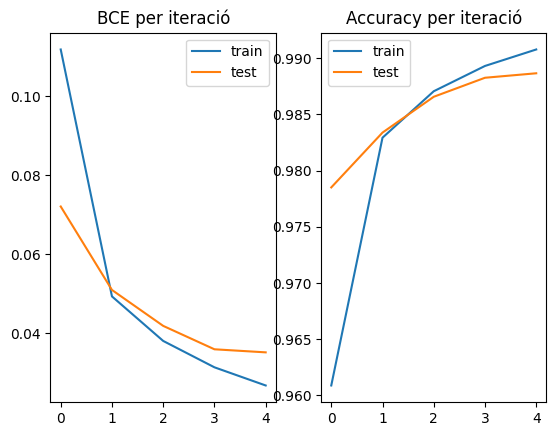

In [8]:
plt.subplot(1,2,1)
plt.title("BCE per iteració")
plt.plot(running_loss, label="train")
plt.plot(running_test_loss, label="test")
plt.legend()

plt.subplot(1,2,2)
plt.title("Accuracy per iteració")
plt.plot(running_acc, label="train")
plt.plot(running_test_acc, label="test")
plt.legend()
plt.show()

In [9]:
print(f"Accuracy de la darrera iteració {running_test_acc[-1]} amb test")

Accuracy de la darrera iteració 0.9886544585987261 amb test





### Nombre de paràmetres entrenables d'una xarxa

**Feina a fer:**
1. Mostrar el nombre de paràmetres de la xarxa: 
```
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
```

In [10]:
#TODO
pytorch_total_params = sum(p.numel() for p in model_mlp.parameters() if p.requires_grad)
print(pytorch_total_params)

7971


In [11]:
pytorch_total_params

7971

## Entrenament CNN

Ara repetirem el mateix que abans, adaptant el codi a la nova arquitectura:

In [12]:
loss_fn = torch.nn.BCEWithLogitsLoss()
learning_rate = 1e-3  # Hiperparàmetre
optimizer = optim.Adam(model_cnn.parameters(), lr=learning_rate)

running_loss = []
running_acc = []

running_test_loss = []
running_test_acc_cnn = []


for t in tqdm(range(EPOCHS), desc="Èpoques"):
    batch_loss = 0
    batch_acc = 0
    
    # Iteram els batches.
    for i_batch, (x, y) in tqdm(enumerate(train_loader), desc=f"Batches (Època {t + 1})"): 
        model_cnn.train() # Posam el model a mode entranament.
        
        #x = x.reshape(x.shape[0], -1) # Aplanam la imatge.
        
        optimizer.zero_grad()

        # 1. PREDICCIÓ
        y_pred = model_cnn(x)

        # 2. CÀLCUL DE LA PÈRDUA
        # Computa la pèrdua: l'error de predicció vs el valor correcte
        # Es guarda la pèrdua en un array per futures visualitzacions

        y_binary = (y == 5)
        y_binary = y_binary.double()
        y_binary = y_binary.reshape(-1, 1)

        loss = loss_fn(y_pred, y_binary)

        #3. GRADIENT
        model_cnn.zero_grad()
        loss.backward()

        # Actualitza els pesos utilitzant l'algorisme d'actualització
        #4. OPTIMITZACIÓ
        with torch.no_grad():
            optimizer.step()
    
        # 5. AVALUAM EL MODEL
        model_cnn.eval() # Mode avaluació de la xarxa
        
        y_pred = model_cnn(x)
        y_pred_binary = (y_pred > 0.5).double()

        batch_loss += (loss_fn(y_pred, y_binary).detach())
        batch_acc += accuracy_score(y_pred_binary.detach(), y_binary.detach())

    running_loss.append(batch_loss / (i_batch + 1))
    running_acc.append(batch_acc / (i_batch + 1))

    batch_test_loss = 0
    batch_test_acc = 0
    
    for i_batch, (x, y) in enumerate(test_loader): 
        
        
        y_binary = (y == 5)
        y_binary = y_binary.double()
        y_binary = y_binary.reshape(-1, 1)

        y_pred = model_cnn(x)
        y_pred_binary = (y_pred > 0.5).double()

        batch_test_loss += (loss_fn(y_pred, y_binary).detach())
        acc = accuracy_score(y_pred_binary.detach(), y_binary.detach())
        batch_test_acc += acc
        

    running_test_loss.append(batch_test_loss / (i_batch + 1))
    running_test_acc_cnn.append(batch_test_acc / (i_batch + 1))

Èpoques:   0%|          | 0/5 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Batches (Època 2): 0it [00:00, ?it/s]

Batches (Època 3): 0it [00:00, ?it/s]

Batches (Època 4): 0it [00:00, ?it/s]

Batches (Època 5): 0it [00:00, ?it/s]

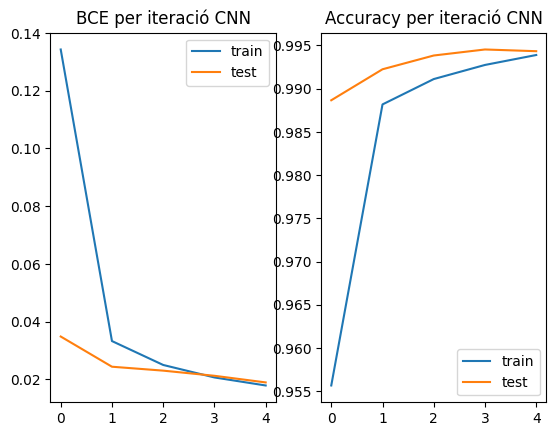

In [13]:
plt.subplot(1,2,1)
plt.title("BCE per iteració CNN")
plt.plot(running_loss, label="train")
plt.plot(running_test_loss, label="test")
plt.legend()

plt.subplot(1,2,2)
plt.title("Accuracy per iteració CNN")
plt.plot(running_acc, label="train")
plt.plot(running_test_acc_cnn, label="test")
plt.legend()
plt.show()

In [14]:
print(f"Accuracy de la darrera iteració {running_test_acc_cnn[-1]} amb test")

Accuracy de la darrera iteració 0.994327229299363 amb test


Ara mirarem el nombre de paràmetres que té aquesta xarxa:

In [15]:
pytorch_total_params = sum(p.numel() for p in model_cnn.parameters() if p.requires_grad)
print(pytorch_total_params)

4387


## Resultats

Aquí visualitzarem els resultats d'aprenentatge de la xarxa. 

### Feina a fer:

1. Fer una predicció del primer _batch_ del conjunt de _test_.
2. Visualitzar una imatge del _batch_ i posar la predicció i el ground truth com a títol.
3. Visualitzar el resultat de la mateixa imatge en tots els filtres de la primera convolució de la vostra xarxa.


*Subplots*

Per fer graelles d'imatges podeu empar la funció `subplots`. Més [informació](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html)



In [16]:
#def generador(loader):
 #   for data, target in loader:
#        yield data, target

gen = generador(test_loader)
data, true_labels = next(gen)

model_cnn.eval()



output = model_cnn(data)
y_pred_binary = (output > 0.5).double()
images = data.numpy()

idx = 8  # El idx 8 és una imatge que conté un 5, el 0 no.

plt.title(f'Pred: {int(y_pred_binary[idx])} - True: {int(true_labels[idx])}')
plt.imshow(images[idx,0,:,:]);

NameError: name 'generador' is not defined

In [ ]:

fig, axs = plt.subplots(2, 2)

convolution = model_cnn[0:5](data)  # Podem accedir a les capes d'un bloc Sequential com si fossin una llista
convolution = convolution.detach().numpy()

axs[0,0].imshow(convolution[idx,0,:,:])
axs[0,1].imshow(convolution[idx,1,:,:])
axs[1,0].imshow(convolution[idx,2,:,:])
axs[1,1].imshow(convolution[idx,3,:,:]);